In [ ]:
%matplotlib inline

<div class="document" id="fuzzy-c-means-clustering">
<h1 class="title">Fuzzy c-means clustering</h1>
<p>Принципы нечёткой логики могут быть использованы для кластеризации многомерных данных, присваивая каждой точке <em>степень принадлежности</em> к каждому центру кластера в диапазоне от 0 до 100 процентов. Это может быть очень эффективным по сравнению с традиционной кластеризацией с жёстким порогом, где каждой точке присваивается чёткая, точная метка.</p>
<p>Кластеризация методом Fuzzy C-Means выполняется с помощью функции <code class="docutils literal">skfuzzy.cmeans</code>, Выходные данные этой функции (например, центроиды кластеров и матрица принадлежности) могут быть использованы для классификации новых данных в соответствии с рассчитанными кластерами. Этот процесс также известен как <em>предсказание</em>) с помощью функции <code class="docutils literal">skfuzzy.cmeans_predict</code>.</p>
<div class="section" id="data-generation-and-setup">
<h1>Генерация данных и настройка</h1>
<p>Вначале выполним необходимые импорты, а затем определим тестовые данные для работы.</p>
</div>
</div>


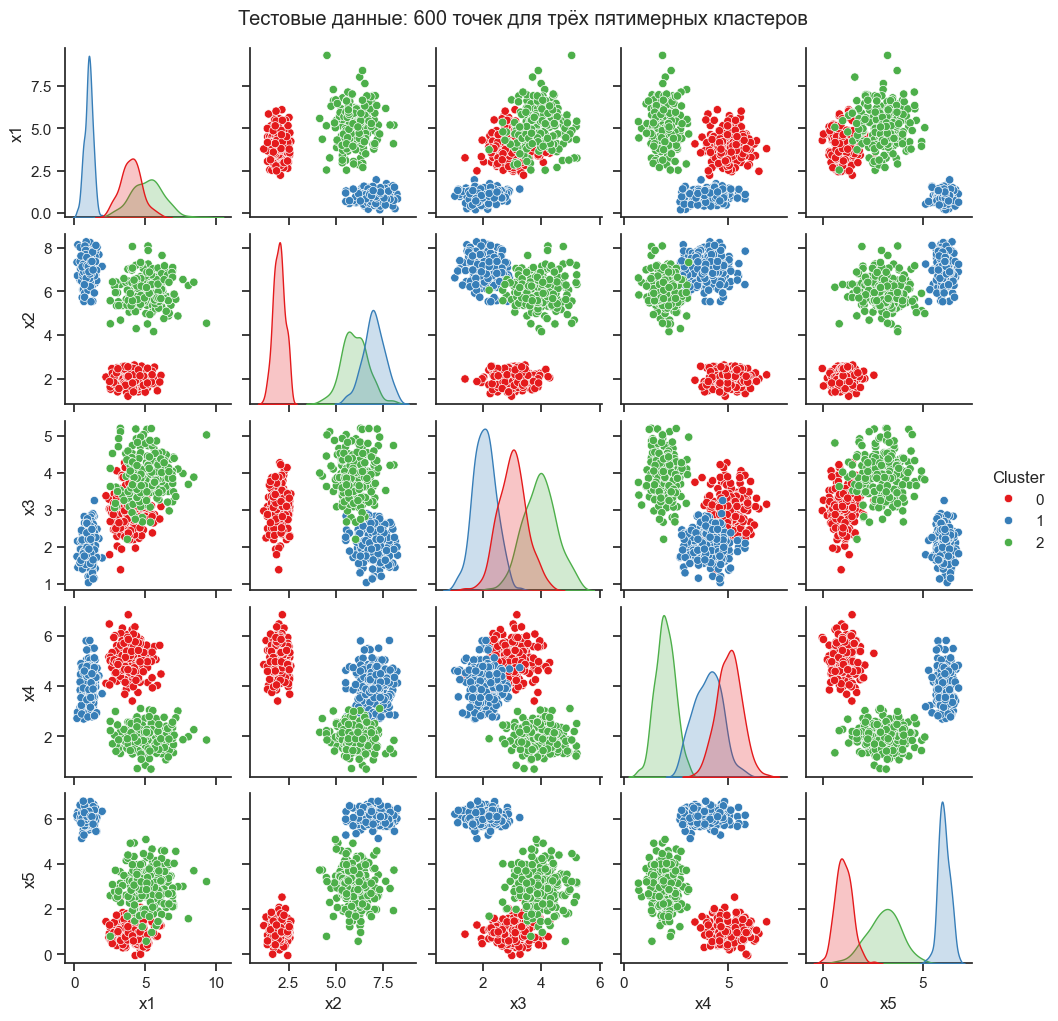

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler

# Определить три центра кластеров для пятимерных данных
centers = [
    [4, 2, 3, 5, 1],  # Центр кластера 0
    [1, 7, 2, 4, 6],  # Центр кластера 1
    [5, 6, 4, 2, 3]   # Центр кластера 2
]

# Определить стандартные отклонения (sigmas) для каждого признака в каждом кластере
sigmas = [
    [0.8, 0.3, 0.5, 0.6, 0.4],  # Sigmas для кластера 0
    [0.3, 0.5, 0.4, 0.7, 0.3],  # Sigmas для кластера 1
    [1.1, 0.7, 0.6, 0.5, 0.8]   # Sigmas для кластера 2
]

# Создать тестовые данные
np.random.seed(42)  # Задать seed для воспроизводимости
data = np.zeros((0, 5))  # Массив для хранения пятимерных точек
labels = np.zeros(0)     # Массив для меток кластеров
for i, (center, sigma) in enumerate(zip(centers, sigmas)):
    # Генерация 200 точек для каждого кластера
    points = np.random.standard_normal((200, 5)) * sigma + center
    data = np.vstack((data, points))
    labels = np.hstack((labels, np.ones(200) * i))

# Создать DataFrame для визуализации
df = pd.DataFrame(data, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df['Cluster'] = labels.astype(int)

# Визуализировать тестовые данные с помощью парного графика
sns.set(style="ticks")
g = sns.pairplot(df, hue='Cluster', palette='Set1', diag_kind='kde', height=2)
g.fig.suptitle('Тестовые данные: 600 точек для трёх пятимерных кластеров', y=1.02)
plt.show()



<div class="document" id="clustering">
<h1 class="title">Кластеризация</h1>
<p>Выше приведены имеющиеся тестовые данные. На них видно три чётко различимых кластера. Однако что произойдёт, если неизвестно, сколько кластеров ожидать? В случае, если данные не так явно кластеризованы?</p>
<p>Попробуем провести кластеризацию данных несколько раз, используя количество кластеров от 2 до 9.</p>
</div>


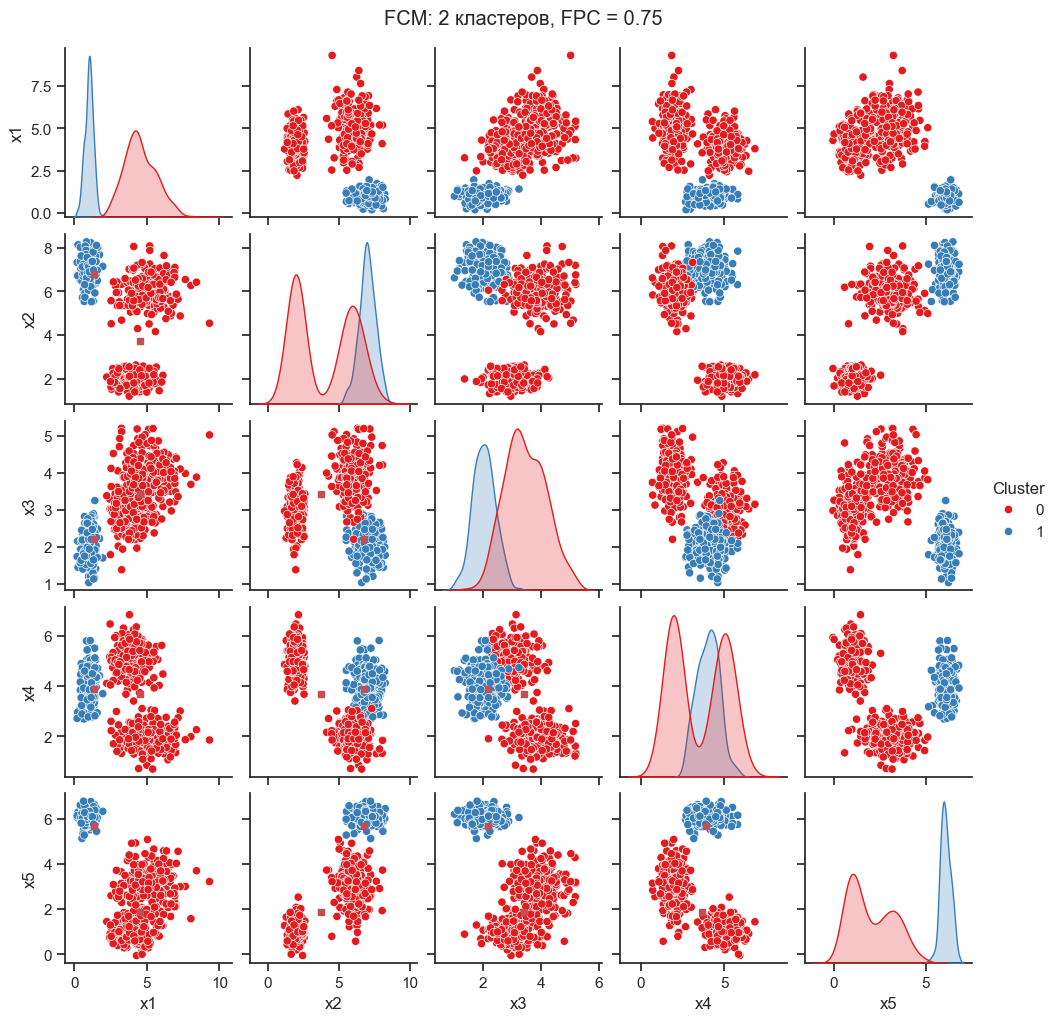

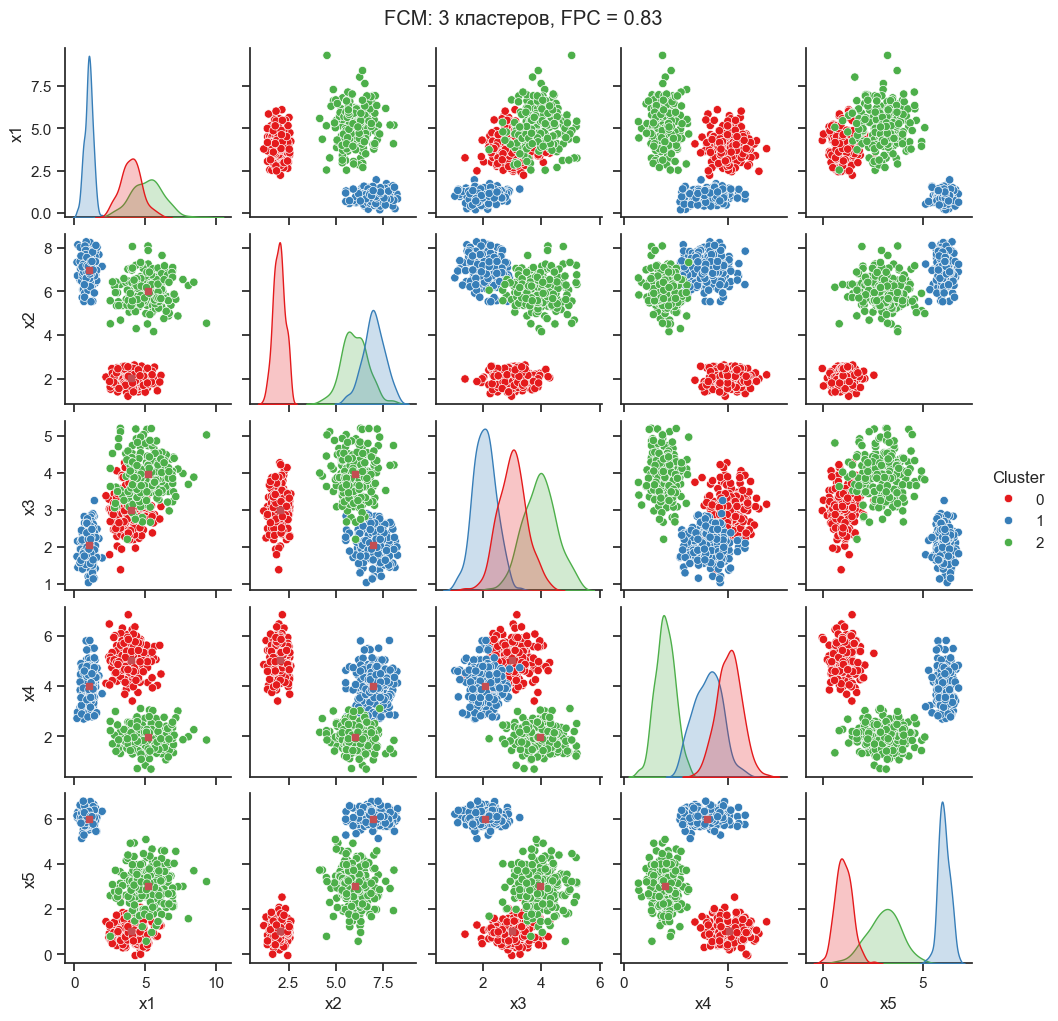

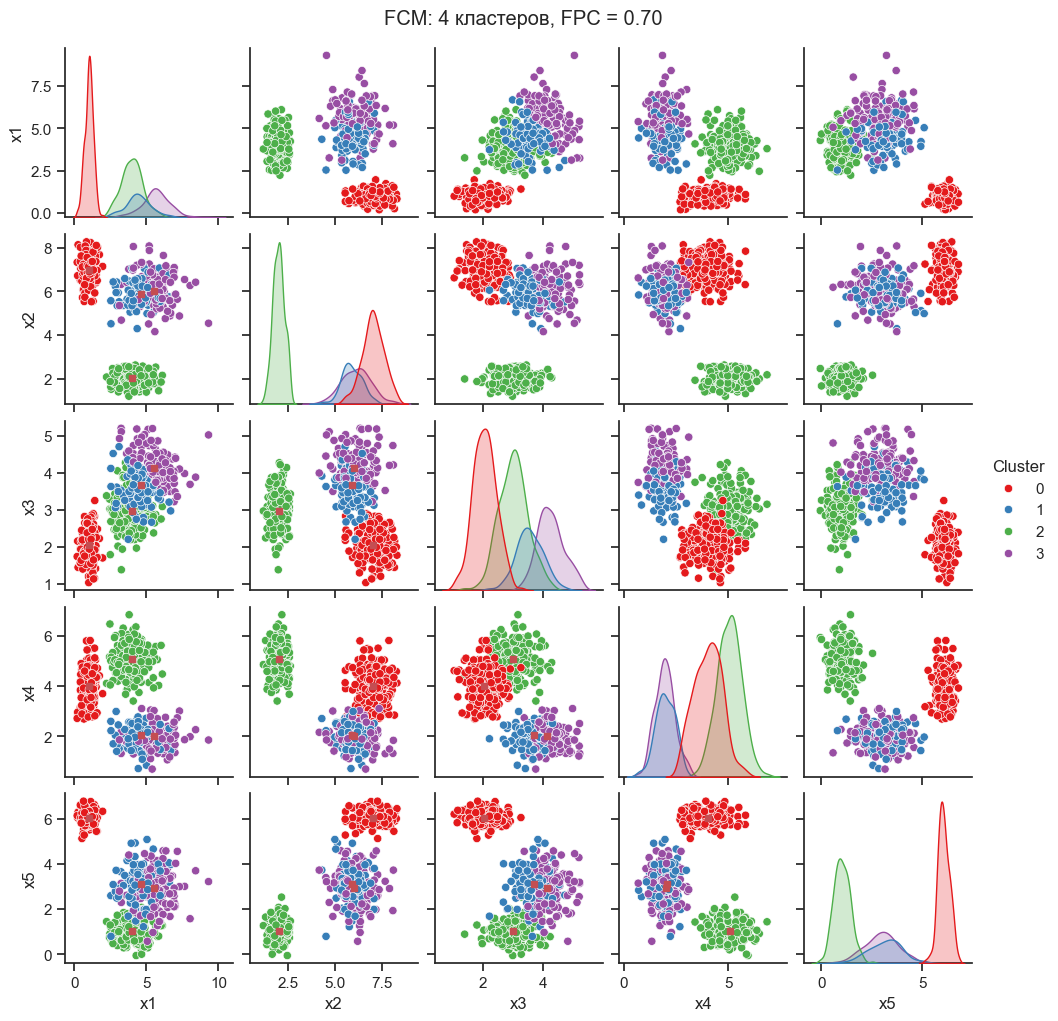

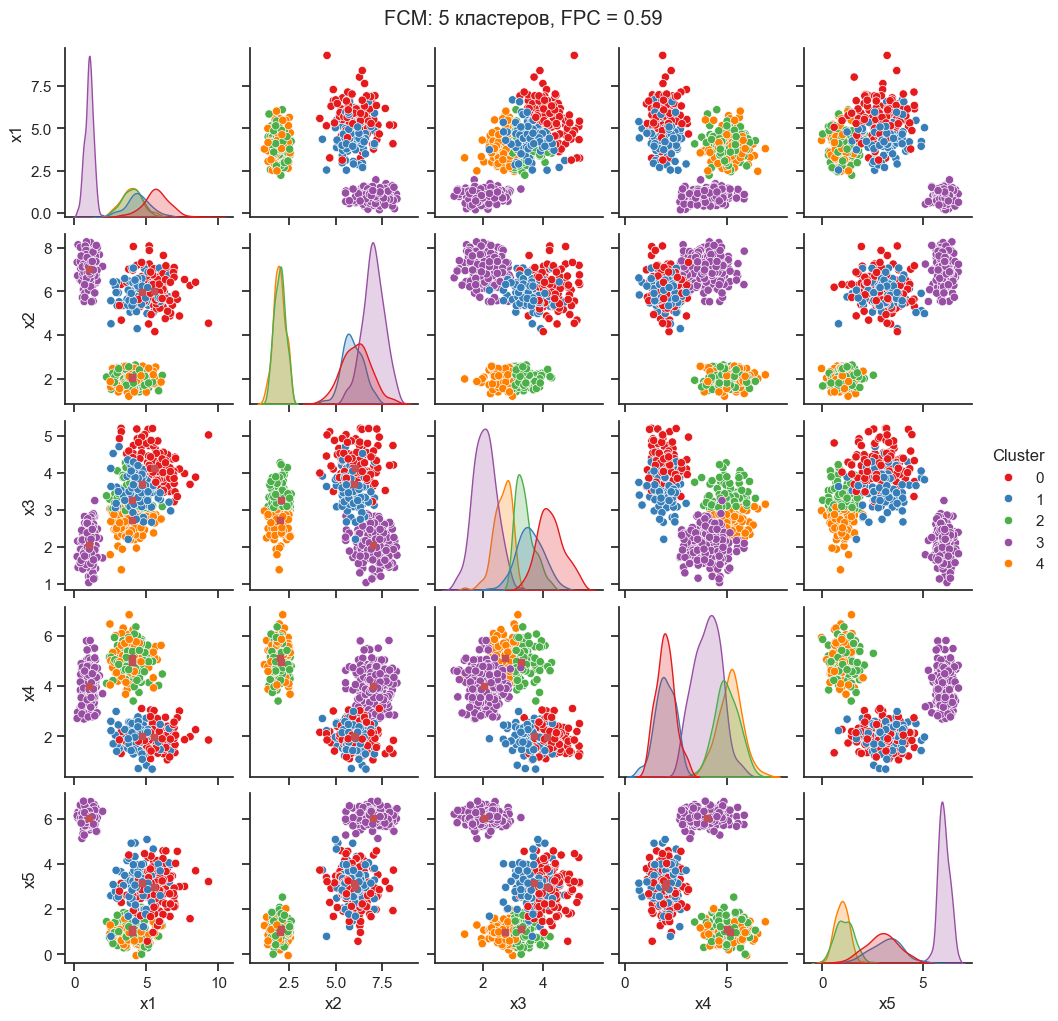

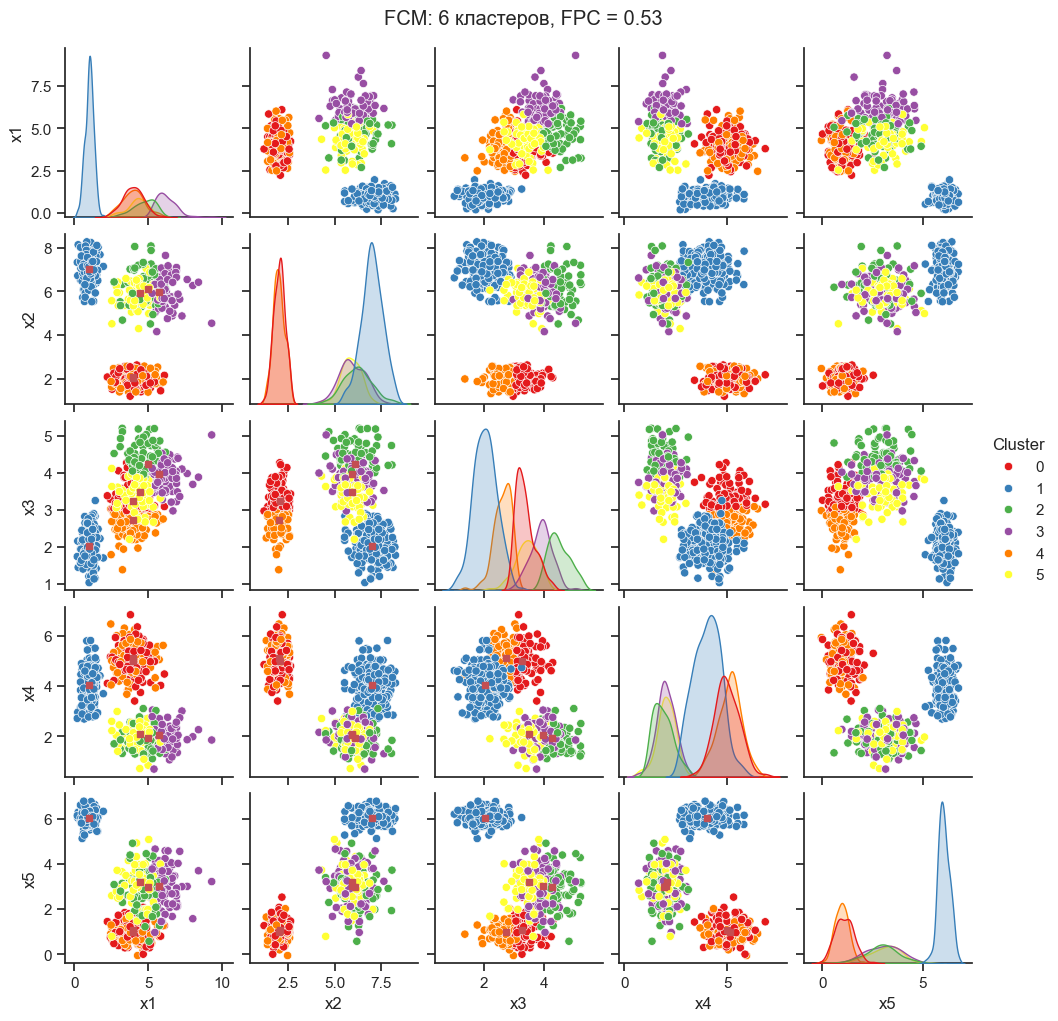

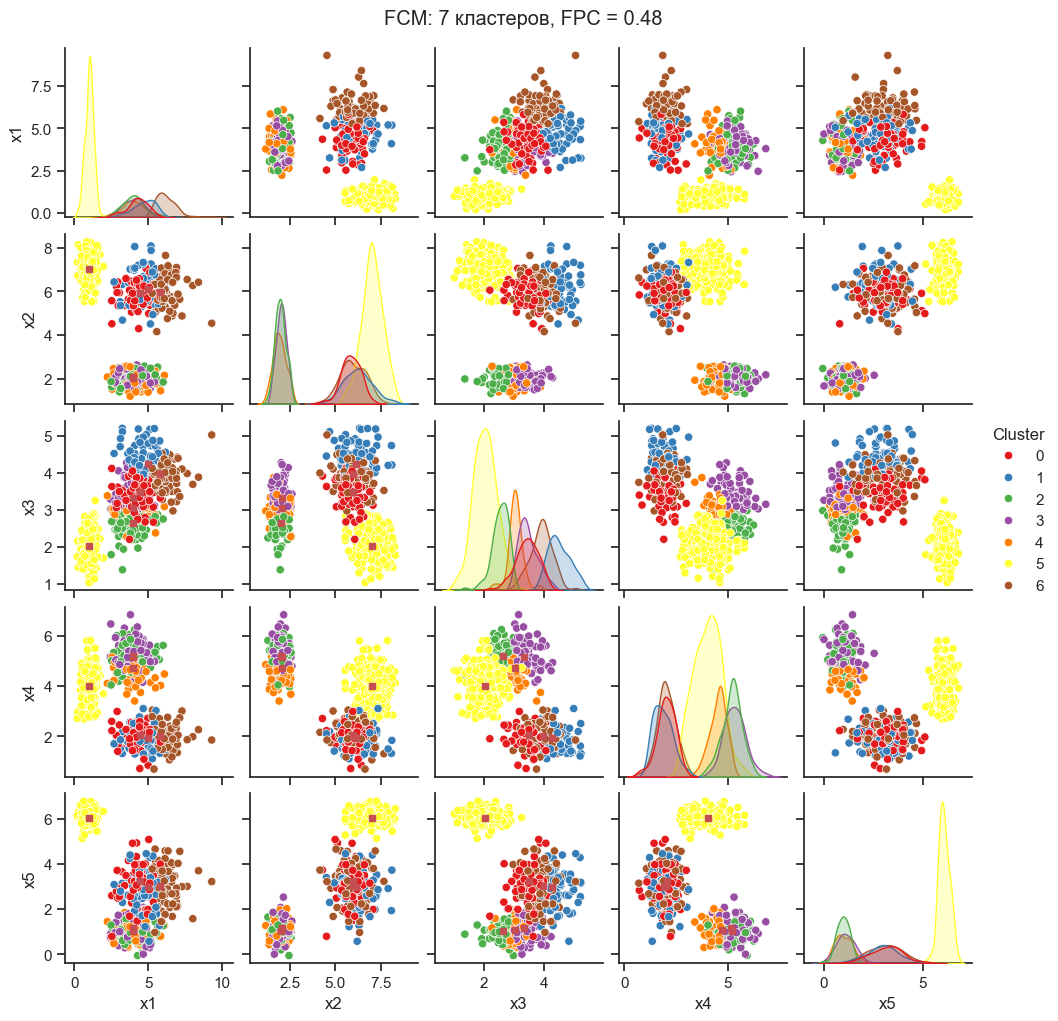

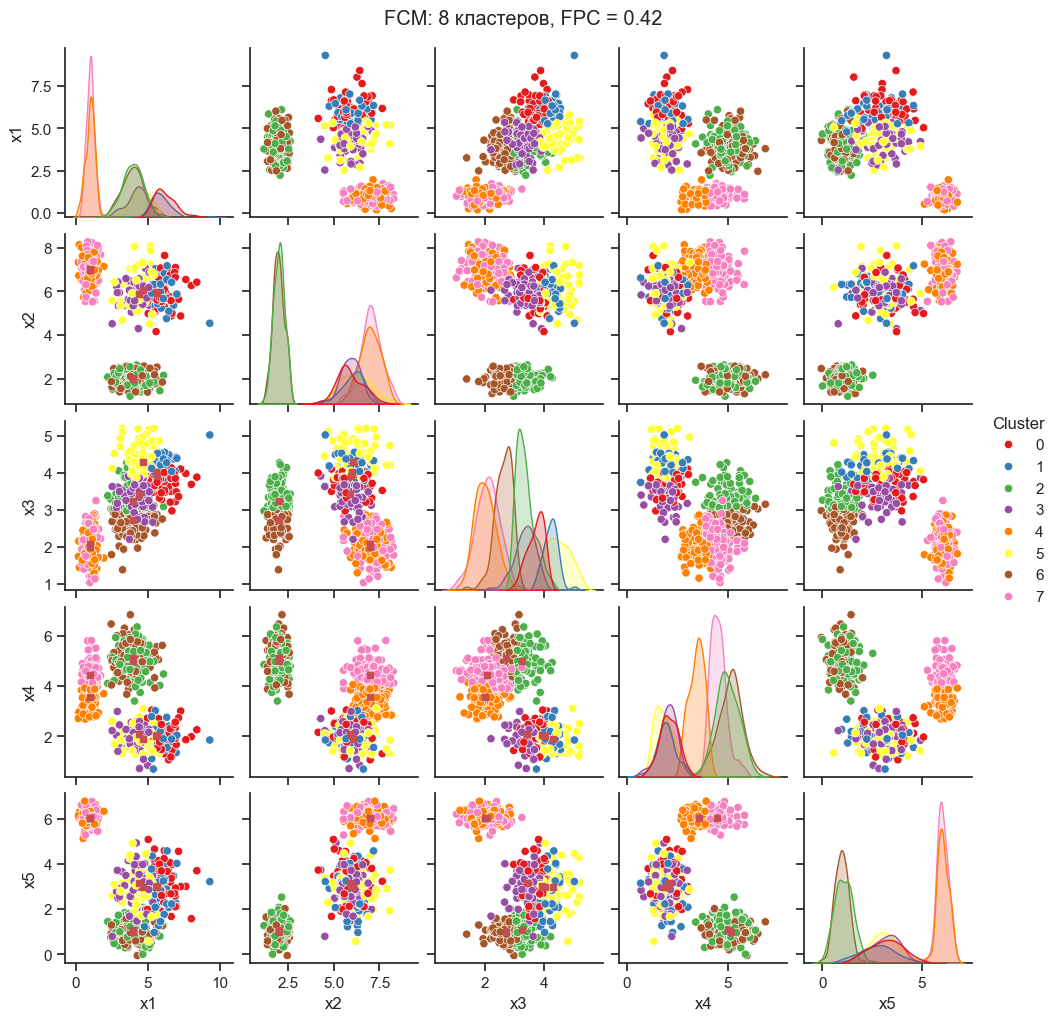

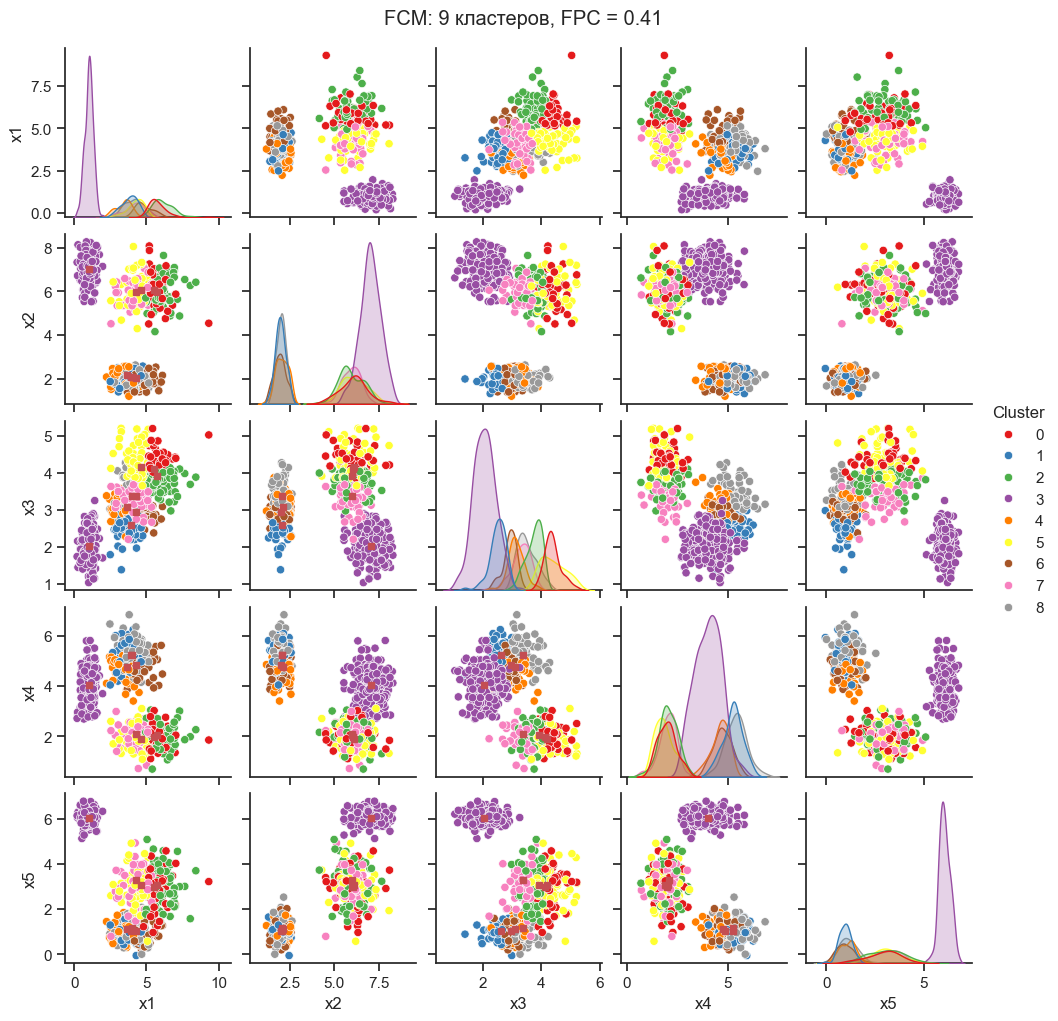

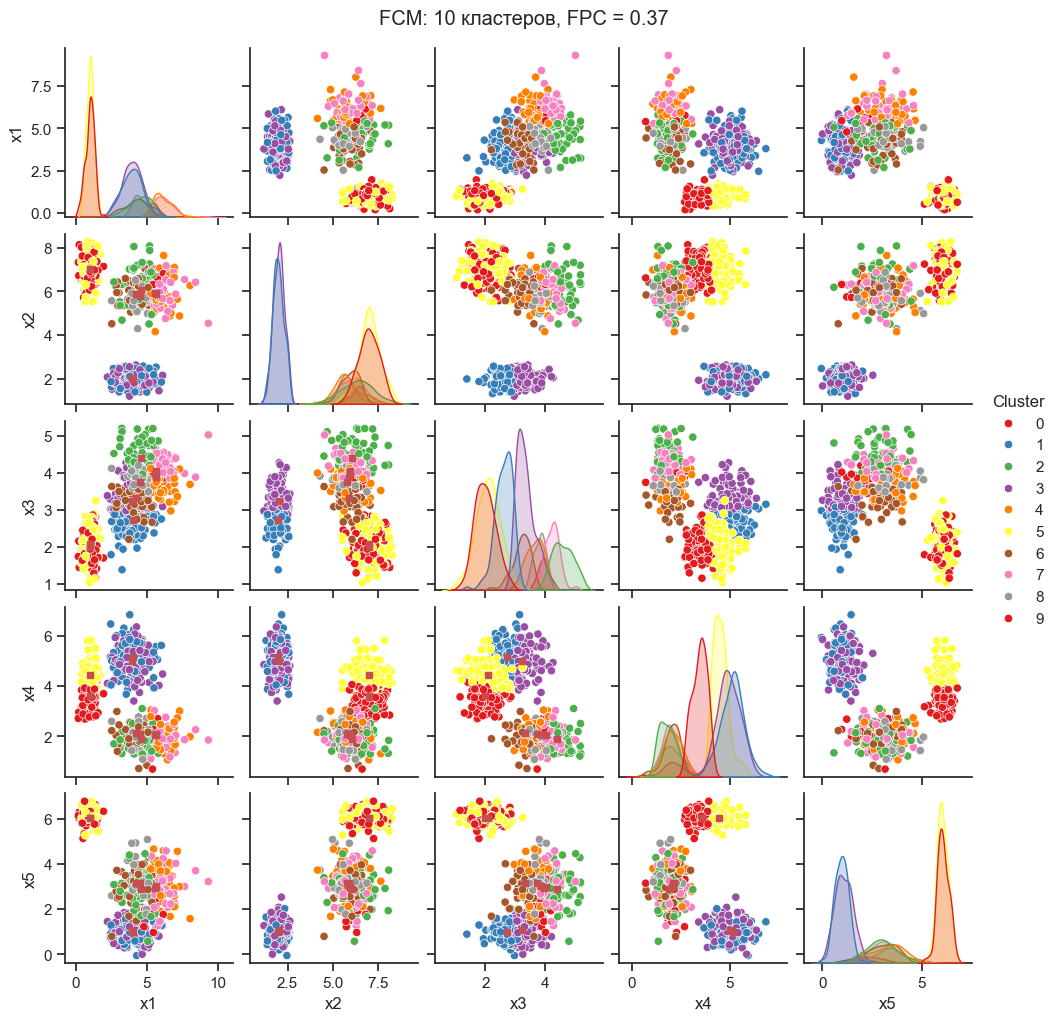

In [9]:

# Стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Подготовка данных для FCM (требуется транспонирование)
alldata = data_scaled.T  # Форма (n_features, n_samples)

# Настройка цикла для кластеризации и визуализации
fpcs = []
n_centers_range = range(2, 11)  # Число кластеров от 2 до 10

for ncenters in n_centers_range:
    # Выполнение Fuzzy C-Means
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None
    )
    
    # Сохранение FPC
    fpcs.append(fpc)
    
    # Определение принадлежности кластерам
    cluster_membership = np.argmax(u, axis=0)
    
    # Создание DataFrame для визуализации
    df = pd.DataFrame(data, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
    df['Cluster'] = cluster_membership
    
    # Визуализация с помощью парного графика
    sns.set(style="ticks")
    g = sns.pairplot(df, hue='Cluster', palette='Set1', diag_kind='kde', height=2)
    g.fig.suptitle(f'FCM: {ncenters} кластеров, FPC = {fpc:.2f}', y=1.02)
    
    # Добавление центроидов (перевод обратно в исходное пространство)
    cntr_unscaled = scaler.inverse_transform(cntr)  # cntr имеет форму (ncenters, 5)
    for pt in cntr_unscaled:
        for i in range(4):
            for j in range(i+1, 5):
                ax = g.axes[j, i]
                ax.plot(pt[i], pt[j], 'rs', markersize=5)
    
    plt.show()


<div class="document" id="the-fuzzy-partition-coefficient-fpc">
<h1 class="title">Коэффициент нечеткого разбиения (FPC)</h1>
<p>Коэффициент нечёткого разбиения (FPC) определён в диапазоне от 0 до 1, где 1 — наилучший показатель. Это метрика, которая показывает, насколько чётко данные описываются определённой моделью. Далее будет проведена кластеризация набора данных, в котором, как известно, присутствует три кластера, несколько раз с использованием от 2 до 9 кластеров. Затем будут показаны результаты кластеризации и построен график коэффициента нечёткого разбиения. Когда FPC достигает максимума, данные описываются наилучшим образом.</p>
</div>


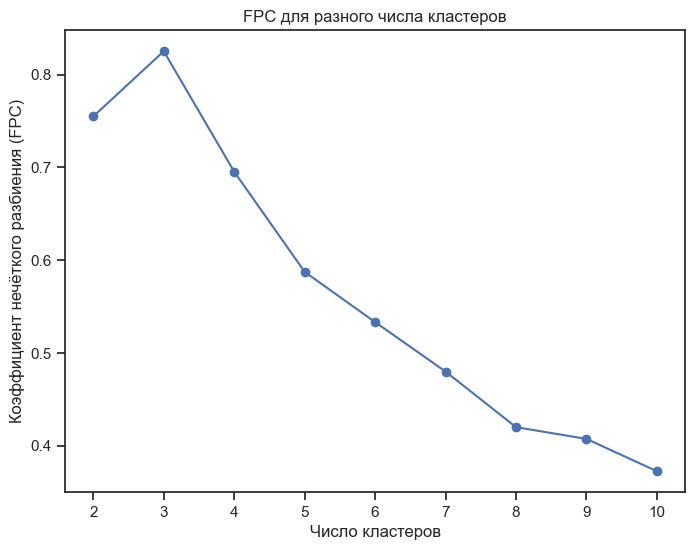

In [10]:

# Построение графика FPC
plt.figure(figsize=(8, 6))
plt.plot(n_centers_range, fpcs, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Коэффициент нечёткого разбиения (FPC)')
plt.title('FPC для разного числа кластеров')
plt.grid(False)
plt.show()



<div class="document">
<p>Как видно, оптимальное количество центров — 3. Для данного искусственного примера это является очевидным, однако использование FPC может оказаться полезным в случаях, когда структура данных неочевидна.</p>
<p>Следует отметить, что начальная кластеризация выполнялась с <em>двумя</em> центрами, а не с одним; кластеризация набора данных с единственным кластером — это тривиальное решение, которое по определению даст значение FPC, равное 1.</p>
<div class="section" id="classifying-new-data">
<h1>Классификация новых данных</h1>
<p>После выполнения кластеризации следующим шагом часто становится отнесение новых точек к уже существующей модели. Этот процесс называется предсказанием. Для его выполнения необходима как существующая модель, так и новые данные, подлежащие классификации.</p>
<div class="section" id="building-the-model">
<h2>Построение модели</h2>
<p>Известно, что наилучшая модель имеет три центра кластера. Заново построим модель с тремя кластерами для последующего использования в предсказании, сгенерируем новые равномерно распределённые данные и определим, к какому кластеру принадлежит каждая новая точка.</p>
</div>
</div>
</div>


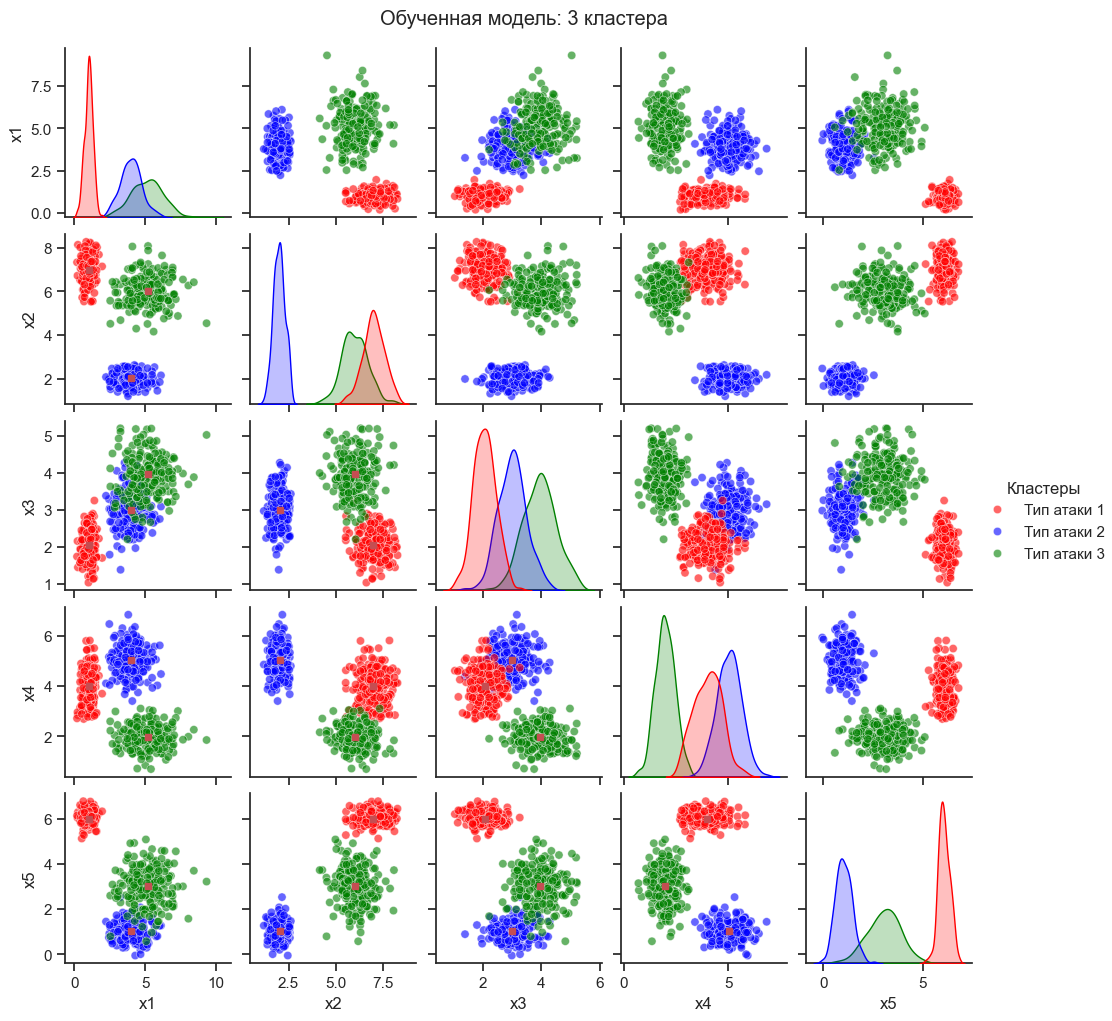

In [ ]:
# Регенерация fuzzy модели с 3 центрами кластеров
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000, init=None
)

# Определение принадлежности кластерам
cluster_membership = np.argmax(u_orig, axis=0)

# Создание DataFrame для визуализации
df = pd.DataFrame(data, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df['Cluster'] = cluster_membership

# Визуализация обученной модели с тремя кластерами
sns.set(style="ticks")
g = sns.pairplot(
    df, 
    hue='Cluster', 
    palette={0: 'red', 1: 'blue', 2: 'green'},
    diag_kind='kde', 
    height=2,
    plot_kws={'alpha': 0.6, 'marker': 'o'},
    hue_order=[0, 1, 2]
)
g.fig.suptitle('Обученная модель: 3 кластера', y=1.02)

# Настройка легенды
g._legend.set_title('Кластеры')
for t, l in zip(g._legend.texts, ['Тип атаки 1', 'Тип атаки 2', 'Тип атаки 3']):
    t.set_text(l)

# Смещение легенды правее
g._legend.set_bbox_to_anchor((0.98, 0.5))  # Координаты (x, y) для центра легенды
g._legend.set_loc('center')  # Выравнивание по центру

# Добавление центроидов
cntr_unscaled = scaler.inverse_transform(cntr)
for pt in cntr_unscaled:
    for i in range(4):
        for j in range(i+1, 5):
            ax = g.axes[j, i]
            ax.plot(pt[i], pt[j], 'rs', markersize=5, label='Центроид' if (i==0 and j==1) else None)

plt.show()

<div class="document" id="prediction">
<h1 class="title">Предсказание</h1>
<p>Наконец, равномерно отберем данные в пределах данной области и классифицируем с помощью функции <code class="docutils literal">cmeans_predict</code>, используя ранее построенную модель.</p>
</div>


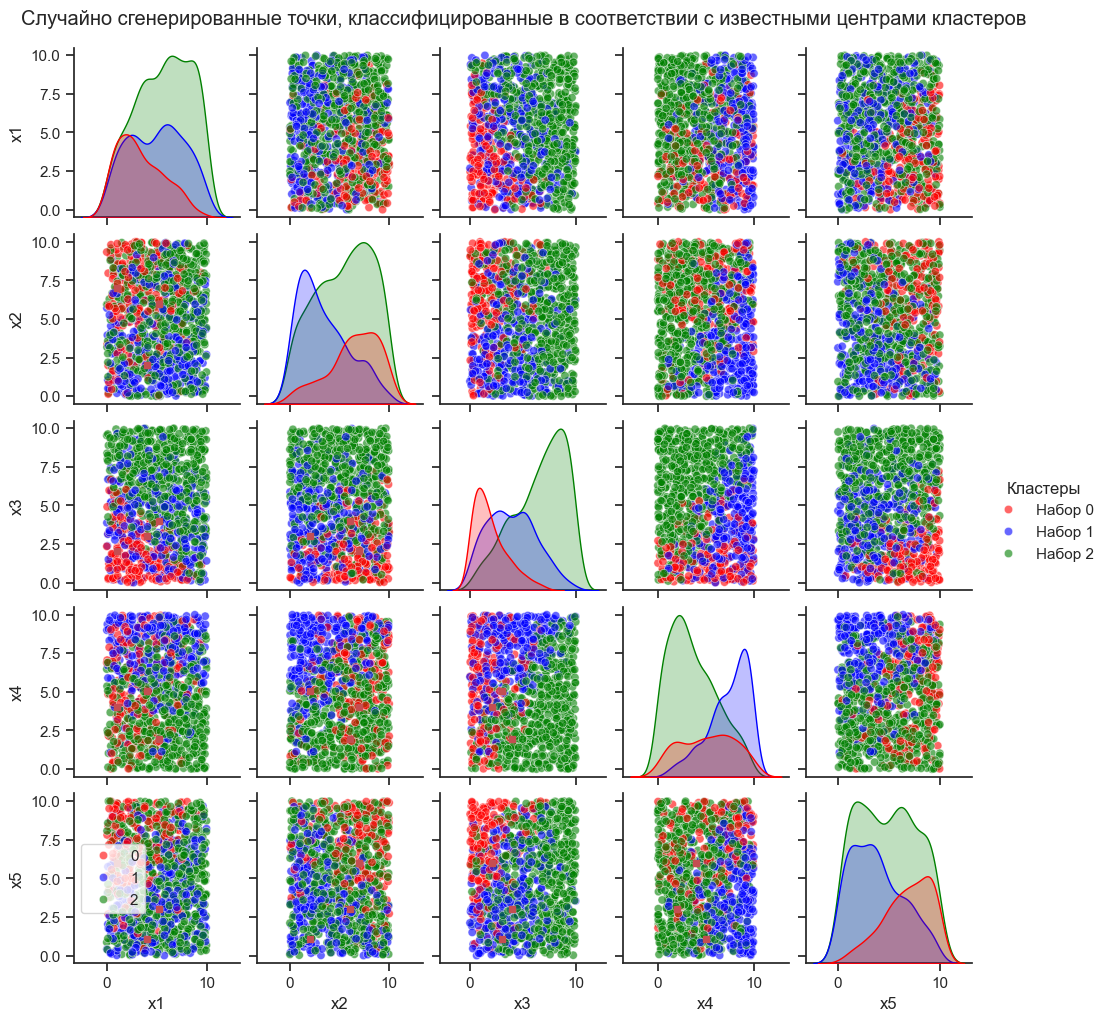

In [26]:

# Генерация новых равномерно распределённых данных в диапазоне [0, 10] для 5 признаков
newdata = np.random.uniform(0, 10, (1100, 5))

# Стандартизация новых данных
newdata_scaled = scaler.transform(newdata)

# Предсказание принадлежности новым точкам с использованием cmeans_predict
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata_scaled.T, cntr, 2, error=0.005, maxiter=1000
)

# Определение принадлежности кластерам (жёсткое разделение для визуализации)
cluster_membership = np.argmax(u, axis=0)

# Создание DataFrame для визуализации
df_new = pd.DataFrame(newdata, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_new['Cluster'] = cluster_membership

# Визуализация классифицированных точек
sns.set(style="ticks")
g = sns.pairplot(
    df_new, 
    hue='Cluster', 
    palette={0: 'red', 1: 'blue', 2: 'green'},
    diag_kind='kde', 
    height=2,
    plot_kws={'alpha': 0.6, 'marker': 'o'},
    hue_order=[0, 1, 2]
)
g.fig.suptitle('Случайно сгенерированные точки, классифицированные в соответствии с известными центрами кластеров', y=1.02)

# Настройка легенды
g._legend.set_title('Кластеры')
for t, l in zip(g._legend.texts, ['Набор 0', 'Набор 1', 'Набор 2']):
    t.set_text(l)

# Смещение легенды правее
g._legend.set_bbox_to_anchor((0.98, 0.5))
g._legend.set_loc('center')

# Добавление центроидов
cntr_unscaled = scaler.inverse_transform(cntr)
for pt in cntr_unscaled:
    for i in range(4):
        for j in range(i+1, 5):
            ax = g.axes[j, i]
            ax.plot(pt[i], pt[j], 'rs', markersize=5, label='Центроид' if (i==0 and j==1) else None)

# Легенда на одной оси
g.axes[4, 0].legend(loc='best')

plt.show()



<div class="document">
</div>
